In [1]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import hurst
import pandas_ta as ta
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from matplotlib.patches import Patch

In [2]:
training_data = pd.read_csv('training_data_non_model.csv')
training_data['Date'] = pd.to_datetime(training_data['Date'])

In [3]:
training_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,return,excess return,daily_risk_free_rate
0,2014-01-02,29.924999,30.070000,29.924999,30.055,23.299053,25400,NaN,NaN,0.000003
1,2014-01-03,29.959999,30.105000,29.959999,30.035,23.283529,22000,-0.066629,-0.066632,0.000003
2,2014-01-06,30.110001,30.270000,30.110001,30.160,23.380447,3200,0.416251,0.416248,0.000003
3,2014-01-07,30.240000,30.260000,30.200001,30.260,23.457973,3800,0.331585,0.331582,0.000003
4,2014-01-08,30.075001,30.184999,30.075001,30.150,23.372700,14800,-0.363514,-0.363517,0.000003


In [4]:
fig = go.Figure(data=[go.Candlestick(x=training_data['Date'],
                open=training_data['Open'],
                high=training_data['High'],
                low=training_data['Low'],
                close=training_data['Close'])])
fig.update_layout(
    title = "Candlestick Chart on Training SPTL Data",
    yaxis_title="Price ($)",
    xaxis_title="Date",
    xaxis_rangeslider_visible=False
    )
fig.show()

In [5]:
# calcualte the linear regression line to identify the trend
from sklearn.linear_model import LinearRegression

# create a new dataframe with only the date and close price
df = training_data[['Close']].copy()
df.index = training_data['Date']
df["Previous Close"] = df['Close'].shift(1)
df = df.dropna()

# create the linear regression model
model = LinearRegression()
model.fit(df[['Previous Close']], df[['Close']])
df['Prediction'] = model.predict(df[['Previous Close']])

In [6]:
# fig1 shows the true data only close price
# fig2 shows only the trend line

fig = go.Figure(data=[go.Scatter(x=training_data["Date"], y=training_data['Close'], mode='lines', name='Trend Line')])

fig.add_trace(go.Scatter(x=training_data["Date"], y=df['Prediction'], mode='lines', name='Trend Line'))

fig.update_layout(
    title = "Trend Line on Training SPTL Data",
    yaxis_title="Price ($)",
    xaxis_title="Date",
    xaxis_rangeslider_visible=False,
    )

fig.show()

In [7]:
H = hurst.compute_Hc(training_data['Close'])

print("Hurst Exponent:", H[0])
print("Hurst Exponent Standard Deviation:", H[1])
print("Hurst Exponent Confidence Intervals:", H[2])

if H[0] > 0.5:
    print("The time series is trending")
else:
    print("The time series is mean reverting")

Hurst Exponent: 0.534940275822673
Hurst Exponent Standard Deviation: 1.1465040931231185
Hurst Exponent Confidence Intervals: [[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1056], [3.749802972991904, 4.844363070839614, 7.524828654014581, 9.815060175627478, 13.775614674416497, 18.908247250316208, 31.038260274878898, 34.59533620228096, 41.96682199579349, 42.21833711534559]]
The time series is trending


In [11]:
# ADX Indicator
adx = training_data.ta.adx(length=14, append=True)
rsi = training_data.ta.rsi()

# Create subplots with shared x-axis
fig = make_subplots(rows=2, cols=1)  # Only one column needed now

# Add candlestick trace
fig.add_trace(go.Candlestick(x=training_data['Date'],
                open=training_data['Open'],
                high=training_data['High'],
                low=training_data['Low'],
                close=training_data['Close'],
                name="Candle stick on SPTL"), row=1, col=1)

fig.update_layout(
    # title = "ADX Indicator on SPTL Training Data",
    xaxis_rangeslider_visible=False,
)

# Add traces
fig.add_trace(go.Scatter(x=training_data['Date'], y=adx['ADX_14'], name='ADX'), row=2, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Date", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="ADX", row=2, col=1)

# Update title and height
# fig.update_layout(title_text="ADX and candle stick on the SPTL training set", height=600)

fig.show()

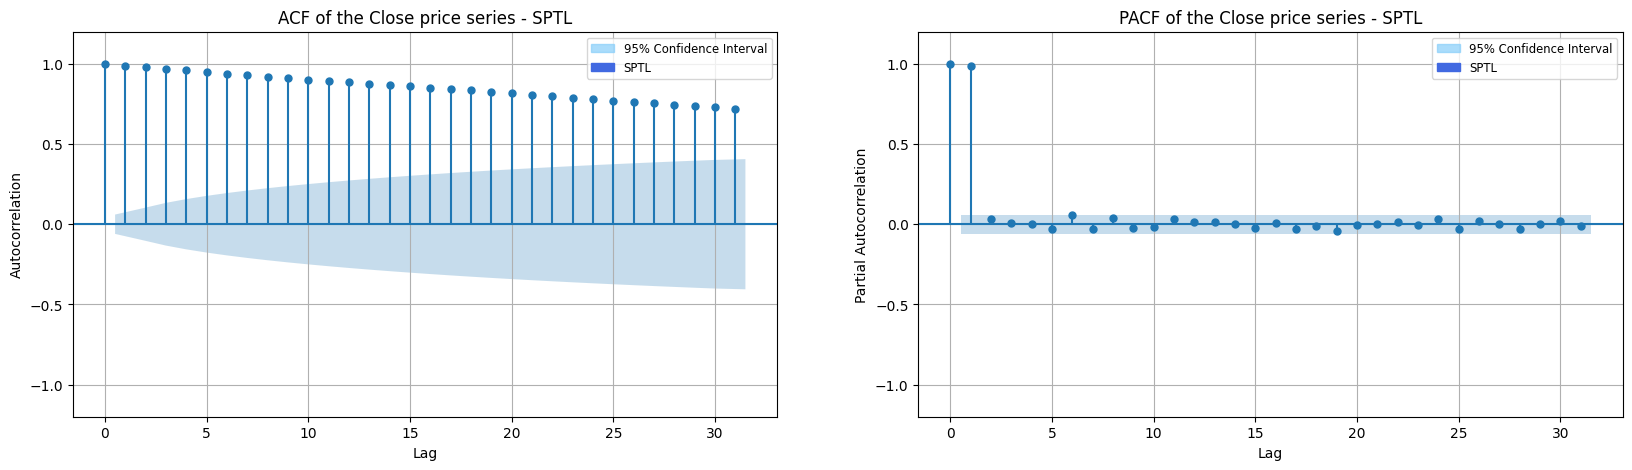

In [9]:
def plot_acf_pacf_in_parallel(values: np.array, etf_name: str, price_type: str = 'Close'):
    legend_patch_confidence = Patch(color='lightskyblue', alpha=0.7, label='95% Confidence Interval')
    legend_patch_series = Patch(color='royalblue', label=etf_name)
    legend = [legend_patch_confidence, legend_patch_series]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    plot_acf(x=values, ax=ax1)
    ax1.set_title(f'ACF of the {price_type} price series - {etf_name}')
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.grid(True)
    ax1.set_ylim(-1.2, 1.2)
    ax1.legend(handles=legend, loc='upper right', fontsize='small')
    plot_pacf(x=values, ax=ax2)
    ax2.set_title(f'PACF of the {price_type} price series - {etf_name}')
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    ax2.grid(True)
    ax2.set_ylim(-1.2, 1.2)
    ax2.legend(handles=legend, loc='upper right', fontsize='small')
    plt.show()

plot_acf_pacf_in_parallel(training_data['Close'], 'SPTL', 'Close')